# Algorithm

1


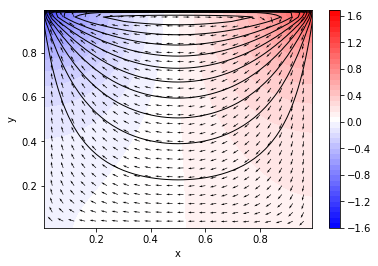

50


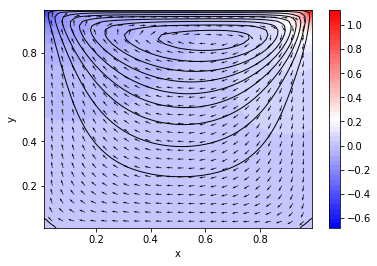

100


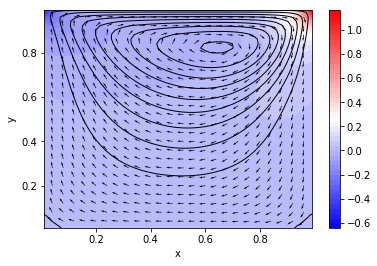

150


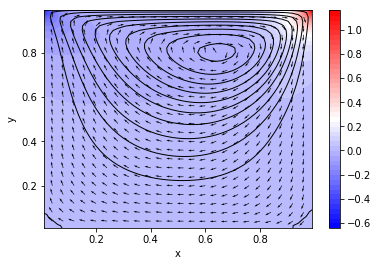

200


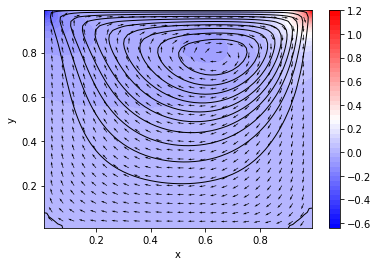

250


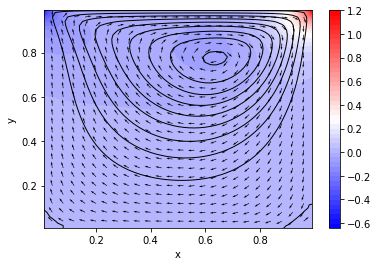

300


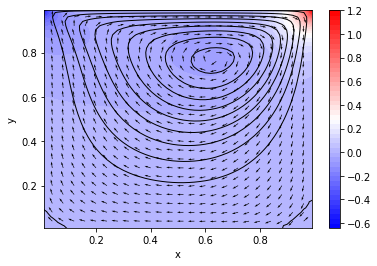

350


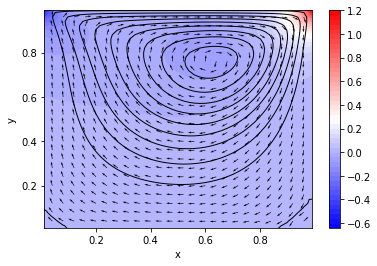

400


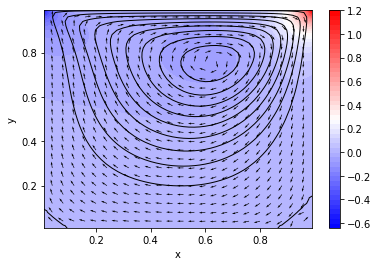

Simulation has ended after 400 iteration(s).


In [4]:
#%matplotlib notebook
import numpy as np
import scipy as sci

import matplotlib.pyplot as plt
from matplotlib import cm

import scipy.sparse as spa
import scipy.sparse.linalg as spala 

from types import SimpleNamespace

from constants import *

# Initial conditions 
const = SimpleNamespace() # Proposal const -> cst
par = SimpleNamespace()

const.Re = 1e2      # Reynolds number
const.dt = 1e-2     # time step
const.tf = 4e0      # final time
const.lx = 1        # width of box
const.ly = 1        # height of box
const.nx = 50       # number of x-gridpoints
const.ny = 50       # number of y-gridpoints
const.nsteps = 10   # number of steps with graphic output
const.lx = 1        # width of box
const.ly = 1        # height of box

const.rho_arrow = 20 # Density of arrows in quiver plot per unit length l
const = constants(const)

# Constuct grid
const.x, const.y = np.linspace(0, const.lx, const.nx+1), np.linspace(0, const.ly, const.ny+1)
const.hx, const.hy = const.lx/const.nx, const.ly/const.ny
[const.X,const.Y] = np.meshgrid(const.y, const.x);
[const.X_ave, const.Y_ave] = np.meshgrid(ave(const.x, 'h'), ave(const.y, 'h'))

# IC's
U = np.zeros((const.nx-1, const.ny), dtype = float)
V = np.zeros((const.nx, const.ny-1), dtype = float)

# BC's
## North, East, South, West
uN = const.x*0 + 1
uE = ave(const.y, 'h')*0 
uS = const.x*0
uW = ave(const.y, 'h')*0

vN = ave(const.x, 'h')*0 
vW = const.y*0
vS = ave(const.x, 'h')*0
vE = const.y*0

# Boundary matrices
Ubc = const.dt/const.Re*((np.vstack((2*uS[1:-1], np.zeros((const.nx-1,const.ny-2),dtype=float).T, 2*uN[1:-1])).T)/const.hx**2 +\
                    np.vstack((uW, np.zeros((const.nx-3, const.ny),dtype=float), uE))/const.hy**2)
Vbc = const.dt/const.Re*((np.vstack((vS, np.zeros((const.nx,const.ny-3), dtype = float).T, vN)).T)/const.hx**2 +\
                    np.vstack((2*vW[1:-1], np.zeros((const.nx-2, const.ny-1),dtype=float), 2*vE[1:-1]))/const.hy**2)

# Operator matrices on P, U, V, Q respectively
Lp = spa.kron(spa.eye(const.ny), laplace_m(const.nx, const.hx, 1)) +\
     spa.kron(laplace_m(const.ny, const.hy, 1), spa.eye(const.nx))
#Lp[0,0] = 3/2*Lp[0,0]   
Lu = spa.eye((const.nx - 1) * const.ny) + \
     (const.dt / const.Re) * ( spa.kron(spa.eye(const.ny), laplace_m(const.nx - 1, const.hx, 2) )  + \
     spa.kron( laplace_m(const.ny, const.hy, 3), spa.eye(const.nx - 1) ) )
Lv = spa.eye((const.ny-1)*const.nx) + \
     (const.dt/const.Re)*(spa.kron(spa.eye(const.ny-1), laplace_m(const.nx, const.hx, 3))+\
     spa.kron(laplace_m(const.ny-1, const.hy, 2), spa.eye(const.nx)))
Lq = spa.kron(spa.eye(const.ny-1), laplace_m(const.nx-1, const.hx, 2)) +\
     spa.kron(laplace_m(const.ny-1, const.hy, 2), spa.eye(const.nx-1))
       

loop = True
counter = 0
fig_counter = 0

while loop:
    counter += 1
    
    # Non linear terms
    Ue = np.vstack((uW, U, uE)).T
    Ue = np.vstack((2*uS-Ue[0,:], Ue ,2*uN-Ue[-1,:])).T

    Ve = np.vstack((vS, V.T, vN)).T
    Ve = np.vstack((2*vW-Ve[0,:], Ve, 2*vE-Ve[-1,:]))
    
    ## Average and difference matrices
    Ua = ave(Ue, 'h')
    Ud = np.diff(Ue, n=1, axis=1)/2
    Va = ave(Ve, 'v')
    Vd = np.diff(Ve, n=1, axis=0)/2
    
    ## Derivative matrices UV_x and UV_y
    UVx = np.diff((Ua*Va - gamma(const, U, V)*np.abs(Ua)*Vd), axis=0)/const.hx
    UVy = np.diff((Ua*Va - gamma(const, U, V)*Ud*np.abs(Va)), axis=1)/const.hy

    ## Average and difference matrices
    Ua = ave(Ue[:,1:-1], 'v')
    Ud = np.diff(Ue[:,1:-1], n=1, axis=0)/2
    Va = ave(Ve[1:-1,:], 'h')
    Vd = np.diff(Ve[1:-1,:], n=1, axis=1)/2
    
    ## Derivative matrices U^2_x and U^2_y
    U2x = np.diff((Ua**2 - gamma(const, U, V)*np.abs(Ua)*Ud), axis=0)/const.hx
    V2y = np.diff((Va**2 - gamma(const, U, V)*np.abs(Va)*Vd), axis=1)/const.hy

    ## Change in velocity applied
    U = U - const.dt*(UVy[1:-1,:] + U2x)
    V = V - const.dt*(UVx[:,1:-1] + V2y)    
        
    # Implicit viscosity 
    u = spala.spsolve(Lu, np.reshape(U + Ubc,(-1,), order='F'))
    U = np.reshape(u,(const.nx-1, const.ny), order='F')
    v = spala.spsolve(Lv, np.reshape(V + Vbc,(-1,), order='F'))
    V = np.reshape(v,(const.nx, const.ny-1), order='F')
    
    # Pressure correction
    grad_U = np.diff(np.vstack((uW, U, uE)), n=1, axis=0)/const.hx +\
             np.diff(np.vstack((vS, V.T, vN)).T, n=1, axis=1)/const.hy
    rhs = np.reshape(grad_U,(-1,), order='F')/const.dt 
    p = -spala.spsolve(Lp, rhs)
    P = np.reshape(p,(const.nx,const.ny), order='F')    
    U = U - np.diff(P, n=1, axis=0)/const.hx*const.dt  
    V = V - np.diff(P, n=1, axis=1)/const.hy*const.dt 

    # Visualization
    '''
    if counter%const.nsteps==0 or counter == 1:
        fig_counter += 1
        print('Counter: ' + str(counter) + ',', 'Time: ' + str(const.dt*counter) + ' s')
        plt.figure()       
    '''
    if counter%50 == 0 or counter == 1:
        print(counter)
        ## Pressure 
        plt.contourf(const.X_ave, const.Y_ave, P.T, 50, cmap='bwr')      
        plt.colorbar()
        
        ## Flow 
        rhs = np.reshape((np.diff(U, n=1, axis=1)/const.hy-np.diff(V, n=1, axis=0)/const.hx),(-1,), order='F')/const.dt
        q = spala.spsolve(Lq, rhs)
        Q = np.zeros((const.nx+1,const.ny+1), dtype=float)
        Q[1:-1,1:-1] = np.reshape((q),(const.nx-1,const.ny-1), order='F')
        plt.contour(const.x, const.y, Q.T, 10, colors='k', linewidths=1)
        
        ## Velocity
        Ue = ave(np.vstack((uW, U, uE)).T, 'v')
        Ue = np.vstack((uS, Ue, uN))
        Ve = ave(np.vstack((vS, V.T, vN)).T, 'v')
        Ve = np.vstack((vW, Ve, vE)).T 
        v_len = np.sqrt(Ue**2 + Ve**2)
        Ue[v_len!=0] = Ue[v_len!=0]/v_len[v_len!=0]
        Ve[v_len!=0] = Ve[v_len!=0]/v_len[v_len!=0]
        plt.quiver(const.x[::const.rho_arrowx], 
                   const.y[::const.rho_arrowy], 
                   Ue[::const.rho_arrowy,::const.rho_arrowx], 
                   Ve[::const.rho_arrowy,::const.rho_arrowx])
       
    
        plt.xlabel('x')
        plt.ylabel('y')
        plt.xlim([np.min(const.X_ave), np.max(const.X_ave)])
        plt.ylim([np.min(const.Y_ave), np.max(const.Y_ave)])
        plt.show()
        ## Save figures 
        #fig_name = f'{fig_counter:04}' # Pad with zeros infront such that number has 4 digits
        #plt.savefig('./movie_images/' + fig_name, dpi=fig.dpi)
        #plt.close()
    
    if counter == np.ceil(const.tf/const.dt):
        loop = False
        print('Simulation has ended after ' + str(counter) + ' iteration(s).')


# Functions

In [2]:
def ave(A, axis):
    """
    axis = h(orizontal), v(ertical) 
    """
    if axis == 'h':
        A = np.transpose(A)
        
    average = (A[0:-1] + A[1:])/2
    
    if axis == 'h':
        average = np.transpose(average)
    
    return average

def gamma(const, U, V):
    """
    Returns gamma factor
    """
    return np.min((1.2*const.dt*np.max((np.max((np.abs(U)/const.hx)),
                                        np.max((np.abs(V)/const.hy)))), 1))

def laplace_m(n, h, bc):
    diag_len = n 
    Lm = 2*np.ones(diag_len)  # Create diagonal values 
    Lu = np.diag(-1*np.ones(diag_len-1), k=1) # Up offdiagonal value 
    Ld = np.diag(-1*np.ones(diag_len-1), k=-1)# Down offdiagonal value 
   
    Lm[[0,-1]] = bc
            
    Lm=np.diag(Lm, k=0)
    
    L = (Lu + Lm + Ld)/h**2
    return L

def visualise_matrix(matrix, label_title):
    """ Visualises matrix by making 2D colourplot.
    
    Parameters
    ----------
    matrix : 2D numpy.ndarray or scipy.sparse.bsr.bsr_matrix
        
    """
    if isinstance(matrix, np.ndarray):
        matrix_plot = matrix
    elif isinstance(matrix, spa.bsr.bsr_matrix) or isinstance(matrix, spa.coo.coo_matrix) or spa.csr.csr_matrix:
        matrix_plot = matrix.toarray()
    plt.imshow(matrix_plot)
    plt.colorbar()
    plt.clim(np.min(matrix_plot), np.max(matrix_plot))
    plt.title(label_title)
    plt.show()

In [ ]:
# This is usefull to get an idea of how the matrices are becoming what they are.
# Use nx and ny to be 4 to see the similarities
'''
plt.spy(Lv)
plt.show()
plt.spy(spa.kron(spa.eye(3), laplace_m(4, 1, 1)))
plt.show()
plt.spy(spa.kron(laplace_m(4, 1, 1), spa.eye(3)))
plt.show()
'''

#visualise_matrix(spa.kron(spa.eye(6), laplace_m(6, 1, 1)), 'hoi')
visualise_matrix(spa.kron(laplace_m(6, 1, 1), spa.eye(6)) +\
                 spa.kron(spa.eye(6), laplace_m(6, 1, 2) ),'hoi2')
hoi = spa.eye((const.nx-1)*const.ny) + ( const.dt / const.Re) * ( spa.kron(spa.eye(const.ny), laplace_m(const.nx - 1, const.hx, 2) )  + \
     spa.kron( laplace_m(const.ny, const.hy, 3), spa.eye(const.nx - 1) ) )
